In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading Data from CSV Files

In [33]:
#reading the csv files into dataframes
microscopy_df = pd.read_csv("../data/microscopy-data.csv")
dunking_df = pd.read_csv("../data/dunking-data.csv")
tr1_df = pd.read_csv("../data/tr-1.csv")
tr2_df = pd.read_csv("../data/tr-2.csv")
tr3_df = pd.read_csv("../data/tr-3.csv")

In [34]:
microscopy_df.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


# K-Means Clustering

Three biscuits were analysed in dunking_df. I thought it would be interesting to see if unsupervised learning could be used to differentiate between these. First I did a PCA to lower the dimensionality of the data so that the clusters could be plotted on 2d and 3d axes

In [5]:
#imports for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

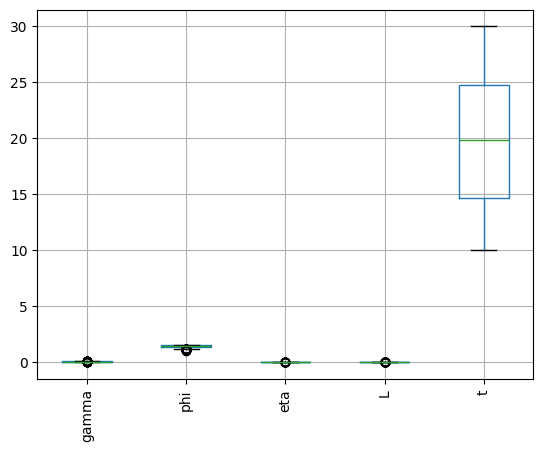

In [6]:
pd.DataFrame(dunking_df).boxplot(rot=90);
plt.show()

In [7]:
dunking_df.head()

,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


In [8]:


dunking_df_without_biscuit = dunking_df.copy()
dunking_df_without_biscuit.drop(columns=['biscuit'], inplace=True)
dunking_df_without_biscuit.head()




,gamma,phi,eta,L,t
0,0.073897,1.333006,0.000999,0.011196,19.362214
1,0.080946,1.476758,0.001012,0.005894,11.852589
2,0.087408,1.477141,0.000984,0.009249,24.793669
3,0.070793,1.502001,0.001002,0.003774,16.292780
4,0.058917,1.548274,0.001004,0.002291,13.662271


In [9]:
dunking_df.head()

,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


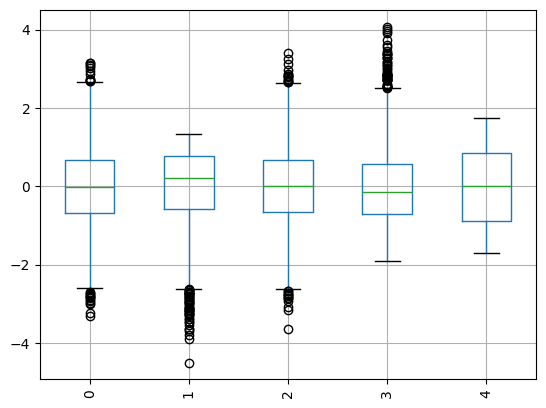

In [10]:
dunking_scaled = StandardScaler().fit_transform(dunking_df_without_biscuit)
#plots a boxplot which shows the scaling of the data
pd.DataFrame(dunking_scaled).boxplot(rot=90);
plt.show()

doing the PCA

In [11]:
pca = PCA(n_components=5)

principalComponents = pca.fit_transform(dunking_scaled)
PCA_components = pd.DataFrame(principalComponents)

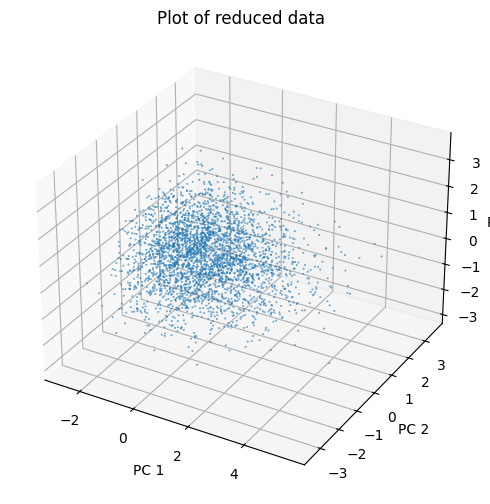

In [12]:
#plotting the principal componants
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(PCA_components[0], PCA_components[1], PCA_components[2], 
            alpha=1, s=0.1)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
ax.set_title("Plot of reduced data")
ax.set_zlabel('PC 3');

for i in range(len(PCA_components[0])):
    x = PCA_components[0][i]
    y = PCA_components[1][i]
    z = PCA_components[2][i]

#    ax.text(x +0.1, y+0.1 , z,element_names[i] , fontsize=10)

plt.show()

In [13]:
# for clustering
from sklearn.cluster import KMeans

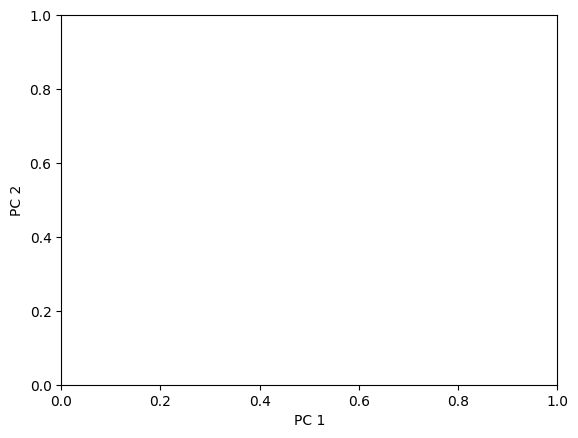

In [14]:
#clusters the data
kmeans = KMeans(n_clusters=3, init = 'random', random_state = 5)
kmeans.fit(PCA_components.iloc[:,:4])

#calculates centeroids
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns = list(PCA_components.iloc[:,:4].columns.values))

#plots data based in three dimensions based on its first 3 principal componants

ax = fig.add_subplot(projection='3d')
labels = kmeans.predict(PCA_components.iloc[:,:4])
ax.scatter3D(PCA_components[0], PCA_components[1], PCA_components[2], alpha=1, c=labels, cmap='Set1', s = 30)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
ax.set_title("Clustered Data")

#plots centeroids
ax.scatter3D([centroids_df[0][0], centroids_df[0][1], centroids_df[0][2]], 
             [centroids_df[1][0], centroids_df[1][1], centroids_df[1][2]],
             [centroids_df[2][0], centroids_df[2][1], centroids_df[2][2]],
             color='k')

#plots the atom labels
for i in range(len(PCA_components[0])):
    x = PCA_components[0][i]
    y = PCA_components[1][i]
    z = PCA_components[2][i]

    #ax.text(x +0.1, y+0.1 , z,element_names[i] , fontsize=10)

plt.show()

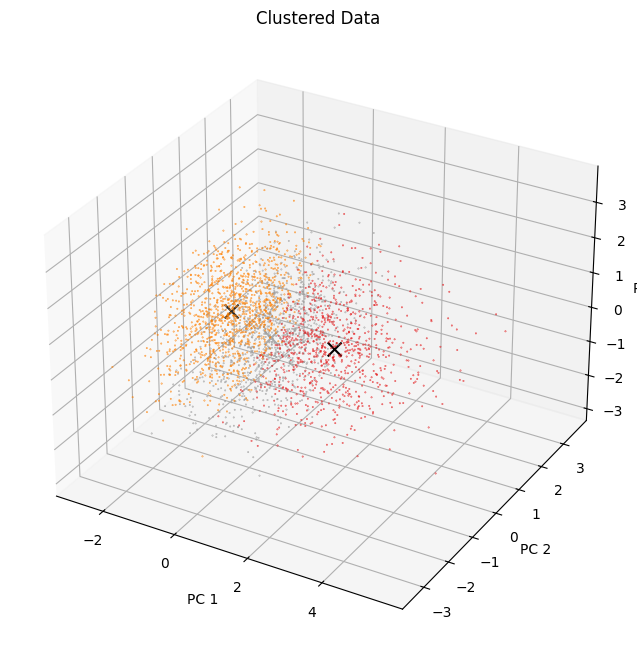

In [15]:
# Clusters the data
kmeans = KMeans(n_clusters=3, init='random', random_state=5)
kmeans.fit(PCA_components.iloc[:, :4])

# Calculates centroids
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=list(PCA_components.iloc[:, :4].columns.values))

# Plots data based on three dimensions based on its first 3 principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Creating 3D plot
labels = kmeans.predict(PCA_components.iloc[:, :4])
ax.scatter3D(PCA_components[0], PCA_components[1], PCA_components[2], alpha=1, c=labels, cmap='Set1', s=0.1)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title("Clustered Data")

# Plots centroids
ax.scatter3D(centroids_df.iloc[:, 0], centroids_df.iloc[:, 1], centroids_df.iloc[:, 2], color='black', s=100, marker='x')

# Plots the atom labels if needed
# for i in range(len(PCA_components[0])):
#     x = PCA_components[0][i]
#     y = PCA_components[1][i]
#     z = PCA_components[2][i]
#     ax.text(x + 0.1, y + 0.1, z, element_names[i], fontsize=10)

plt.show()


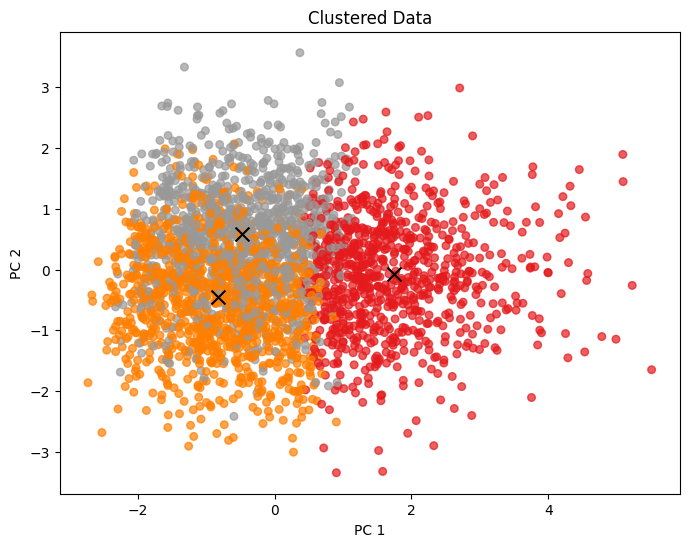

In [16]:
# Clusters the data
kmeans = KMeans(n_clusters=3, init='random', random_state=5)
kmeans.fit(PCA_components.iloc[:, :4])

# Calculates centroids
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=list(PCA_components.iloc[:, :4].columns.values))

# Plots data based on two dimensions based on its first 2 principal components
plt.figure(figsize=(8, 6))
labels = kmeans.predict(PCA_components.iloc[:, :4])
plt.scatter(PCA_components[0], PCA_components[1], alpha=0.7, c=labels, cmap='Set1', s=30)
plt.scatter(centroids_df.iloc[:, 0], centroids_df.iloc[:, 1], color='black', s=100, marker='x')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title("Clustered Data")

# Plots the atom labels if needed
# for i in range(len(PCA_components[0])):
#     x = PCA_components[0][i]
#     y = PCA_components[1][i]
#     plt.text(x + 0.1, y + 0.1, element_names[i], fontsize=10)

plt.show()


In [17]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# # Load the data
# data = dunking_df

# # Separate features and target variable
# X = data.drop(columns=['biscuit'])
# y = data['biscuit']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# # Build the neural network model
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     Dense(64, activation='relu'),
#     Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with softmax activation for classification
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# # Evaluate the model
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print('Test accuracy:', test_acc)

# Testing Fluid Flow Equation

In [18]:
print(microscopy_df["phi"])

0      1.557367
1      1.538842
2      1.546138
3      1.566878
4      1.570229
         ...   
495    1.481847
496    1.488293
497    1.554817
498    1.439910
499    1.524417
Name: phi, Length: 500, dtype: float64


In [19]:
#defining the washburn equation
def washburn_eqn(gamma, r, t, phi, eta):
    length = np.sqrt((gamma*r*t*np.cos(phi))/(2*eta))
    return length

In [20]:
dunking_df.head()

,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


In [21]:
microscopy_df["predicted_L"] = washburn_eqn(microscopy_df["gamma"], microscopy_df["r"], microscopy_df["t"], microscopy_df["phi"], microscopy_df["eta"])

In [22]:
microscopy_df.head()

,gamma,phi,eta,L,t,r,predicted_L
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07,0.003233
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07,0.002436
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07,0.003027
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07,0.001251
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07,0.000567


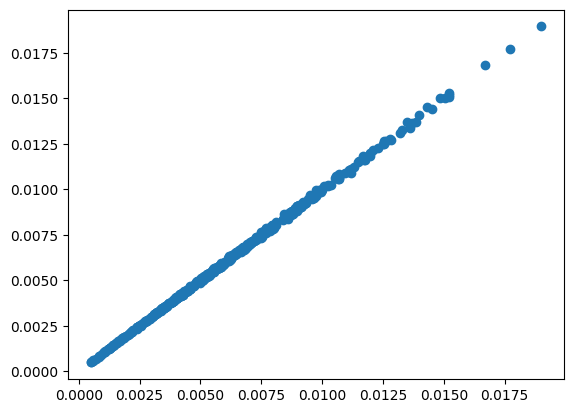

In [23]:
fig , ax = plt.subplots()

ax.scatter(microscopy_df["L"], microscopy_df["predicted_L"])

plt.show()

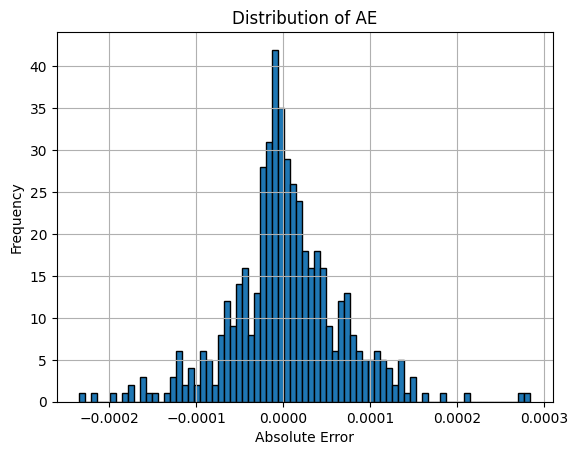

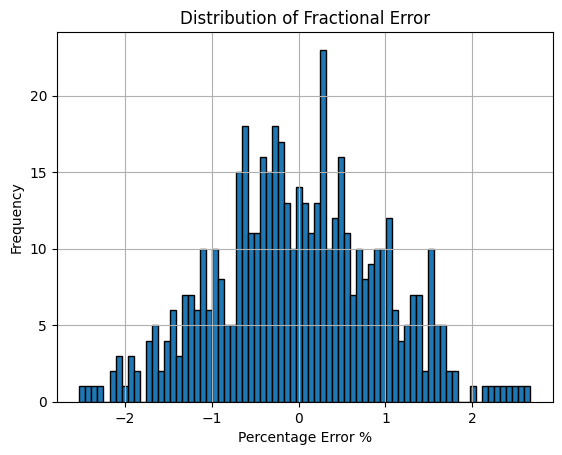

In [24]:
microscopy_df["absolute_error"] = microscopy_df["L"] - microscopy_df["predicted_L"]
microscopy_df["fractional_error"] = microscopy_df["absolute_error"] / microscopy_df["L"]

# Plot Absolute Error histogram
plt.hist(microscopy_df["absolute_error"], bins=75, edgecolor='black')  # 'bins' determines the number of bins
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of AE')
plt.grid(True)
plt.show()
# Plot Fratcional error histogram
plt.hist(microscopy_df["fractional_error"]*100, bins=75, edgecolor='black')  # 'bins' determines the number of bins
plt.xlabel('Percentage Error %')
plt.ylabel('Frequency')
plt.title('Distribution of Fractional Error')
plt.grid(True)
plt.show()

# Exploring Microscopy

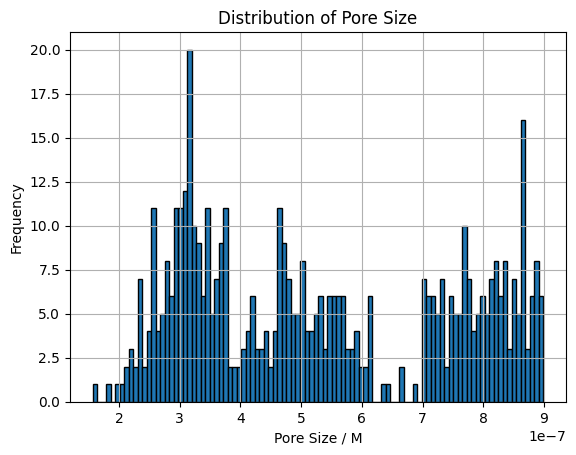

In [40]:
# Plot Fratcional error histogram
plt.hist(microscopy_df["r"], bins=100, edgecolor='black')  # 'bins' determines the number of bins
plt.xlabel('Pore Size / M')
plt.ylabel('Frequency')
plt.title('Distribution of Pore Size')
plt.grid(True)
plt.show()

# Exploring TR1

In [ ]:
print("tr1_df")

# Exploring the Dunking Dataset

In [26]:
dunking_df.head()

,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


In [27]:
print(f"There are {len(dunking_df[dunking_df['biscuit'] == 'Digestive'])} Digestives")
print(f"There are {len(dunking_df[dunking_df['biscuit'] == 'Hobnob'])} Hobnobs")
print(f"There are {len(dunking_df[dunking_df['biscuit'] == 'Rich Tea'])} Rich Teas")

There are 1000 Digestives
There are 1000 Hobnobs
There are 1000 Rich Teas


In [28]:
print()